# Follow-up experiments at physiological temperature

In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns
import pandas as pd
import matplotlib
import pickle
import scipy
import time
import warnings

import rnaseqTools

def sns_styleset():
    sns.set(context='paper', style='ticks', font='DejaVu Sans')
    matplotlib.rcParams['axes.linewidth']    = .5
    matplotlib.rcParams['xtick.major.width'] = .5
    matplotlib.rcParams['ytick.major.width'] = .5
    matplotlib.rcParams['xtick.minor.width'] = .5
    matplotlib.rcParams['ytick.minor.width'] = .5
    matplotlib.rcParams['xtick.major.size'] = 2
    matplotlib.rcParams['ytick.major.size'] = 2
    matplotlib.rcParams['xtick.minor.size'] = 1
    matplotlib.rcParams['ytick.minor.size'] = 1
    matplotlib.rcParams['font.size']       = 6
    matplotlib.rcParams['axes.titlesize']  = 6
    matplotlib.rcParams['axes.labelsize']  = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['xtick.labelsize'] = 6
    matplotlib.rcParams['ytick.labelsize'] = 6
    matplotlib.rcParams['figure.dpi'] = 120

sns_styleset()

In [2]:
# Import Patch-seq data

from collections import namedtuple
houstonData = namedtuple('houstonData', 'exonCounts intronCounts cells genes layers cre yields traced \
                                         depth thickness ephys ephysNames exclude \
                                         mice_ages mice_cres morphometrics morphometricsNames zProfiles \
                                         exonLengths intronLengths')
m1 = pickle.load(open('../data/processed/rnaseq/m1.pickle', 'rb'))
ttypes = pickle.load(open('../data/processed/rnaseq/ttypes.pickle', 'rb'))

# M1 cluster colors and names
m1data = pickle.load(open('../data/processed/reduced-allen-data/SmartSeq_cells_AIBS.pickle', 'rb'))
clusterColors = m1data['neurons']['clusterColors']
clusterNames = m1data['neurons']['clusterNames']
clusterN = clusterNames.size

# Our layer definition
with np.errstate(invalid='ignore'):
    layers = m1.layers.copy()
    normdepth = m1.depth/m1.thickness
    layers[normdepth < 0.07] = '1'
    layers[(normdepth > 0.07) & (normdepth < 0.29)] = '2/3'
    layers[(normdepth > 0.29) & (normdepth < 0.73)] = '5'
    layers[normdepth > 0.73] = '6'

## Load the 34C data

In [3]:
data_exons = pd.read_csv('../data/m1_patchseq_phys_temp_exon_counts.csv.gz', 
                   na_filter=False, index_col=0)
exonCounts = data_exons.values.transpose()
exonCounts = scipy.sparse.csr_matrix(exonCounts)
genes = np.array(data_exons.index)

print('Count matrix shape (exon):  ', exonCounts.shape)

data_introns = pd.read_csv('../data/m1_patchseq_phys_temp_intron_counts.csv.gz', 
                   na_filter=False, index_col=0)
intronCounts = data_introns.values.transpose()
intronCounts = scipy.sparse.csr_matrix(intronCounts)
assert(all(data_introns.index==data_exons.index))

print('Count matrix shape (intron):', intronCounts.shape)

data = pd.read_csv('../data/gene_lengths.txt')
data = data.set_index('GeneID')
data = data.loc[genes]

exonLengths = data['exon_bp'].values
intronLengths = data['intron_bp'].values

Count matrix shape (exon):   (185, 30749)
Count matrix shape (intron): (185, 30749)


In [4]:
data = pd.read_csv('../data/m1_patchseq_phys_temp_meta_data.csv', sep='\t')
thickness = data['Cortical thickness (µm)'].values
depth = data['Soma depth (µm)'].values

# Our layer definition
with np.errstate(invalid='ignore'):
    layers34 = np.array(['   '] * depth.size)
    normdepth = depth/thickness
    layers34[normdepth < 0.07] = '1'
    layers34[(normdepth > 0.07) & (normdepth < 0.29)] = '2/3'
    layers34[(normdepth > 0.29) & (normdepth < 0.73)] = '5'
    layers34[normdepth > 0.73] = '6'
    
cells = data['Cell']

In [5]:
# EPHYS DATA

ephysData = pd.read_csv('../data/m1_patchseq_phys_temp_ephys_features.csv')
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData['cell id'].values
ephysData = ephysData.values[:,1:].astype('float')
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array([names2ephys[c] if c in names2ephys else ephysData[0]*np.nan for c in cells])

print('Number of cells with ephys data:', np.sum(np.isin(cells, ephysCells)))

Number of cells with ephys data: 184


In [6]:
m1_34 = houstonData(exonCounts=exonCounts, intronCounts=intronCounts,
                     cells=cells, genes=genes,
                     ephys=ephysData, ephysNames=ephysNames,
                     exonLengths=exonLengths, intronLengths=intronLengths,
                     layers=None, cre=None, yields=None, traced=None, depth=None, thickness=None,
                     exclude=None, mice_ages=None, mice_cres=None, morphometrics=None,
                     morphometricsNames=None,zProfiles=None)

## T-type assignment

In [7]:
def consensus_assignment(counts, genes, intronCounts=None, exonLengths=None, intronLengths=None):
    
    results = {}
    n = counts.shape[0]
    
    # Map to Tasic for QC    
    tasic2018 = pickle.load(open('../data/processed/reduced-allen-data/tasic2018.pickle', 'rb'))
    if intronCounts is not None:
        tasicAss, tasicCorrs = rnaseqTools.map_to_clusters(tasic2018['counts'], tasic2018['genes'],
                counts, genes, tasic2018['clusters'], returnCmeans=True,
                newIntronCounts=intronCounts, referenceIntronCounts=tasic2018['intronCounts'],
                newExonLengths=exonLengths, newIntronLengths=intronLengths,
                normalizeNew=True, normalizeReference=True)        
    else:
        tasicAss, tasicCorrs = rnaseqTools.map_to_clusters(tasic2018['counts'], tasic2018['genes'],
                counts, genes, tasic2018['clusters'], returnCmeans=True)
    tasicCorrs[np.isnan(tasicCorrs)] = 0

    excl = np.amax(tasicCorrs, axis=1) < .4
    print('Excluded because max corr < .4:                   {}'.format(np.sum(excl)))
    lowq = excl
    
    excl = ~lowq & (np.amax(tasicCorrs[:,:117], axis=1) < .4)
    print('Excluded because max neural corr < .4:            {}'.format(np.sum(excl)))
    lowq |= excl
    
#     excl = ~lowq & (np.amax(tasicCorrs[:,117:], axis=1) > np.amax(tasicCorrs[:,:117], axis=1))
#     print('Excluded because non-neural corr > neural corr:   {}'.format(np.sum(excl)))
#     lowq |= excl
    
    excl = ~lowq & np.isin(np.argmax(tasicCorrs,axis=1), [115,116])
    print('Excluded because mapping to Meis2/CR:             {}'.format(np.sum(excl)))
    lowq |= excl
    
    orderBorders = [0,29,60,115]
    tasicCorrs_maxOrder = np.zeros((n, len(orderBorders)-1))
    for i in range(len(orderBorders)-1):
        tasicCorrs_maxOrder[:,i] = np.amax(tasicCorrs[:,orderBorders[i]:orderBorders[i+1]], axis=1) 
    orderDelta = np.diff(np.sort(tasicCorrs_maxOrder,axis=1)[:,-2:], axis=1).squeeze()
    excl = ~lowq & (orderDelta<0.02)
    print('Excluded because the delta between orders < 0.02: {}'.format(np.sum(excl)))
    lowq |= excl

    results['qc'] = np.array(['low quality'] * n, dtype='object')
    results['qc'][~lowq] = 'good'
    results['tasicCorrs'] = tasicCorrs
    
    tasicOrder = np.argmax(tasicCorrs_maxOrder, axis=1)
    tasicOrder[lowq] = -1
    
    # Bootstrap Tasic for good cells
    if intronCounts is not None:
        ass, ass_boot = rnaseqTools.map_to_clusters(tasic2018['counts'], tasic2018['genes'],
                counts[~lowq,:], genes, tasic2018['clusters'], bootstrap=True, seed=42,
                newIntronCounts=intronCounts[~lowq,:], referenceIntronCounts=tasic2018['intronCounts'],
                newExonLengths=exonLengths, newIntronLengths=intronLengths,
                normalizeNew=True, normalizeReference=True)        
    else:
        ass, ass_boot = rnaseqTools.map_to_clusters(tasic2018['counts'], tasic2018['genes'],
                counts[~lowq,:], genes, tasic2018['clusters'], bootstrap=True, seed=42)

    results['tasic_ass'] = np.zeros(n) * np.nan
    results['tasic_ass'][~lowq] = ass

    results['tasic_ass_boot'] = np.zeros((n, tasic2018['clusterNames'].size)) * np.nan
    results['tasic_ass_boot'][~lowq, :] = ass_boot

    
    # Consensus over M1 datasets
    results['m1ass'] = {}
    results['m1corrs'] = {}
    results['m1boot'] = {}

    for dataset in ['10X_cells_v2_AIBS', '10X_nuclei_v2_AIBS',
                '10X_cells_v3_AIBS', '10X_nuclei_v3_AIBS',
                'SmartSeq_cells_AIBS', 'SmartSeq_nuclei_AIBS',
                '10X_nuclei_v3_Broad']:
    
        m1data = pickle.load(open('../data/processed/reduced-allen-data/' + dataset + '.pickle', 'rb'))
        K = m1data['neurons']['clusterNames'].size
        results['m1ass'][dataset] = np.zeros(n) * np.nan
        results['m1corrs'][dataset] = np.zeros((n, K)) * np.nan
        results['m1boot'][dataset] = np.zeros((n, K)) * np.nan
    
        for order, referenceKey in enumerate(['viplamp', 'pvsst', 'exc']):
            subset = (tasicOrder == order)

            if intronCounts is not None:
                ass, ass_boot, Cmeans = rnaseqTools.map_to_clusters(
                m1data[referenceKey]['counts'], m1data[referenceKey]['genes'],
                counts[subset,:], genes, m1data[referenceKey]['clusters'], 
                bootstrap=True, returnCmeans=True, seed=42, totalClusters=K,
                newIntronCounts=intronCounts[subset,:], 
                referenceIntronCounts=m1data[referenceKey]['intronCounts'] if 'SmartSeq' in dataset else None,
                newExonLengths=exonLengths, newIntronLengths=intronLengths,
                normalizeNew=True, normalizeReference='SmartSeq' in dataset)
                
            else:
                ass, ass_boot, Cmeans = rnaseqTools.map_to_clusters(
                m1data[referenceKey]['counts'], m1data[referenceKey]['genes'],
                counts[subset,:], genes, m1data[referenceKey]['clusters'], 
                bootstrap=True, returnCmeans=True, seed=42, totalClusters=K)
        
            results['m1ass'][dataset][subset] = ass
            results['m1corrs'][dataset][subset,:] = Cmeans
            results['m1boot'][dataset][subset,:] = ass_boot
        
    results['m1consensus_boot'] = np.zeros((n, K))
    for dataset in results['m1boot']:
        results['m1consensus_boot'] += results['m1boot'][dataset]
    results['m1consensus_boot'] /= len(results['m1boot'])

    results['m1consensus_ass'] = np.zeros(n) * np.nan
    mapped = np.sum(~np.isnan(results['m1consensus_boot']), axis=1) > 0
    results['m1consensus_ass'][mapped] = np.argmax(results['m1consensus_boot'][mapped,:], axis=1)
    
    # Final type and family
    results['type'] = np.array([''] * n, dtype='object')
    results['type'][~lowq] = clusterNames[results['m1consensus_ass'][~lowq].astype(int)]

    results['family'] = np.array(['low quality'] * n, dtype='object')
    families = ['Lamp5']*8 + ['Sncg']*5 + ['Vip']*14 + ['Sst']*20 + ['Pvalb']*10 + \
               ['IT']*12 + ['ET']*4 + ['NP']*4 + ['CT']*11
    results['family'][~lowq] = [families[i] for i in results['m1consensus_ass'][~lowq].astype(int)]
    
    results['confidence'] = np.zeros(n) * np.nan
    results['confidence'][~lowq] = np.max(results['m1consensus_boot'][mapped,:], axis=1)
    
    return results

In [8]:
ttypes34 = consensus_assignment(m1_34.exonCounts, m1_34.genes, intronCounts=m1_34.intronCounts,
                                exonLengths=m1_34.exonLengths, intronLengths=m1_34.intronLengths)

Using a common set of 2454 genes.
Excluded because max corr < .4:                   5
Excluded because max neural corr < .4:            2
Excluded because mapping to Meis2/CR:             0
Excluded because the delta between orders < 0.02: 1
Using a common set of 2454 genes.
.................................................................................................... done
Using a common set of 466 genes.
.................................................................................................... done
Using a common set of 473 genes.
.................................................................................................... done
Using a common set of 435 genes.
.................................................................................................... done
Using a common set of 468 genes.
.................................................................................................... done
Using a common set of 452 genes.
.............................

In [9]:
# Export

tasic2018 = pickle.load(open('../data/processed/reduced-allen-data/tasic2018.pickle', 'rb'))
n = m1_34.exonCounts.shape[0]

totalCounts = m1_34.exonCounts + m1_34.intronCounts

with open('../data/processed/rnaseq/rnatypes-phys-temp.csv', 'wt') as f:
    for num in range(n):
        print(np.sum(totalCounts[num,:]>0), file=f, end='\t')
        
        print(ttypes34['family'][num], file=f, end='\t')
        print(ttypes34['type'][num], file=f, end='\t')
        
        if ttypes34['family'][num] != 'low quality':
            print('{:.2f}'.format(ttypes34['confidence'][num]), file=f, end='\t')

            row = ttypes34['m1consensus_boot'][num]
            ind = np.argsort(row)[::-1]
            ind = ind[:np.where(np.cumsum(row[ind]) >= .95)[0][0] + 1]
            ind = ind[:3]
            mystring = []
            for i in ind:
                s = clusterNames[i] + ' ({:.1f}%)'.format(100*row[i])
                mystring.append(s)
            print(', '.join(mystring), file=f, end='\t') 

            row = ttypes34['tasic_ass_boot'][num]
            ind = np.argsort(row)[::-1]
            ind = ind[:np.where(np.cumsum(row[ind]) >= .95)[0][0] + 1]
            ind = ind[:3]
            mystring = []
            for i in ind:
                s = tasic2018['clusterNames'][i] + ' ({:.1f}%)'.format(100*row[i])
                mystring.append(s)
            print(', '.join(mystring), file=f) 

        else:
            print('\t\t', file=f)

(121423, 2)


<IPython.core.display.Javascript object>


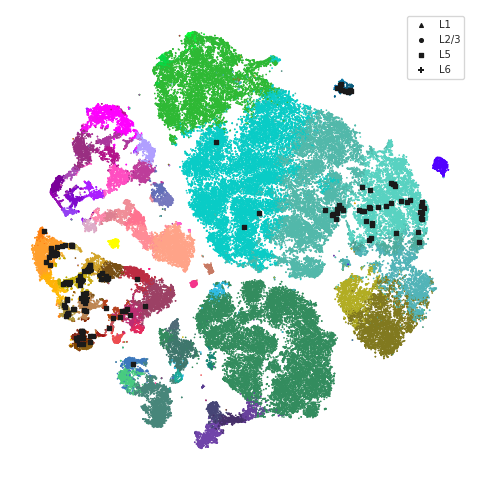

Using a common set of 907 genes.


In [10]:
shapes = {'1': '^', '2/3': 'o', '5': 's', '6': '+'}
sizes  = {'1': 5,   '2/3': 5,   '5': 4,   '6': 15}

m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))
Z = pickle.load(open('../data/processed/rnaseq/10x-tsne-big.pickle', 'rb'))

print(Z.shape)

plt.figure(figsize=(4,4))
plt.scatter(Z[:,0], Z[:,1], s=1, alpha=1,
            c = clusterColors[m1data['neurons']['clusters']], edgecolor='none',
            rasterized=True)

plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)
plt.tight_layout()

pos = rnaseqTools.map_to_tsne(m1data['neurons']['counts'],
                              m1data['neurons']['genes'],
                              m1_34.exonCounts[ttypes34['qc']=='good',:], m1_34.genes, Z, knn=10,
                              newIntronCounts=m1_34.intronCounts[ttypes34['qc']=='good',:], 
                              newExonLengths=m1_34.exonLengths, newIntronLengths=m1_34.intronLengths,
                              normalizeNew=True, normalizeReference=False)
sc = []    
for L in ['1', '2/3', '5', '6']:
    s = plt.scatter(pos[layers34[ttypes34['qc']=='good']==L,0], 
                    pos[layers34[ttypes34['qc']=='good']==L,1], 
                    s=sizes[L], c='k', zorder=2, marker=shapes[L], rasterized=True)
    sc.append(s)
plt.legend(sc, ['L1','L2/3','L5','L6'])

In [11]:
print(np.unique(ttypes34['family'], return_counts=True))
print(np.sum(layers34=='5'))
print(np.sum(~np.isnan(m1_34.ephys[:,0])))

(array(['ET', 'IT', 'NP', 'Pvalb', 'Sst', 'low quality'], dtype=object), array([ 12,  43,   2,  10, 110,   8]))
175
184


## L5 Sst cells

<IPython.core.display.Javascript object>


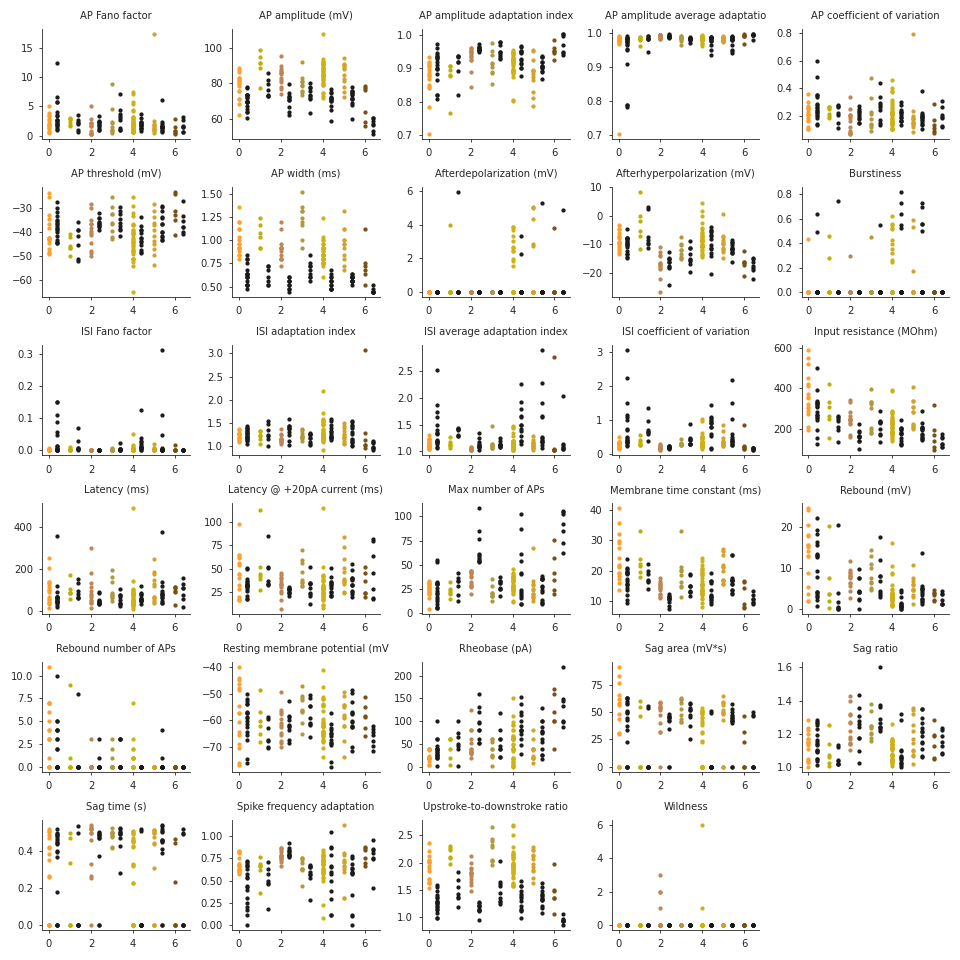

In [12]:
# Full comparison of all ephys features

plt.figure(figsize=(8,8))
for i in range(m1.ephysNames.size):
    plt.subplot(6,5,i+1)
    subset   = (ttypes['family']=='Sst') & (layers=='5') & (m1.exclude=='')
    subset34 = (ttypes34['family']=='Sst') & (layers34=='5')
    x = 0
    for t in range(clusterN):
        ind = subset & (ttypes['type']==clusterNames[t])
        ind34 = subset34 & (ttypes34['type']==clusterNames[t])
        if (np.sum(ind) >= 5) & (np.sum(ind34) >=5):
            plt.scatter(x + np.zeros(np.sum(ind)), m1.ephys[ind,:][:,i],
                       color = clusterColors[t], s = 3)
            plt.scatter(x + .4 + np.zeros(np.sum(ind34)), m1_34.ephys[ind34,:][:,i],
                       color = 'k', s = 3)
            x += 1
    plt.title(m1.ephysNames[i][:30])
sns.despine()
plt.tight_layout()

# plt.savefig('figures/revision/sst-comparison-allEphys.png', dpi=400)

<IPython.core.display.Javascript object>


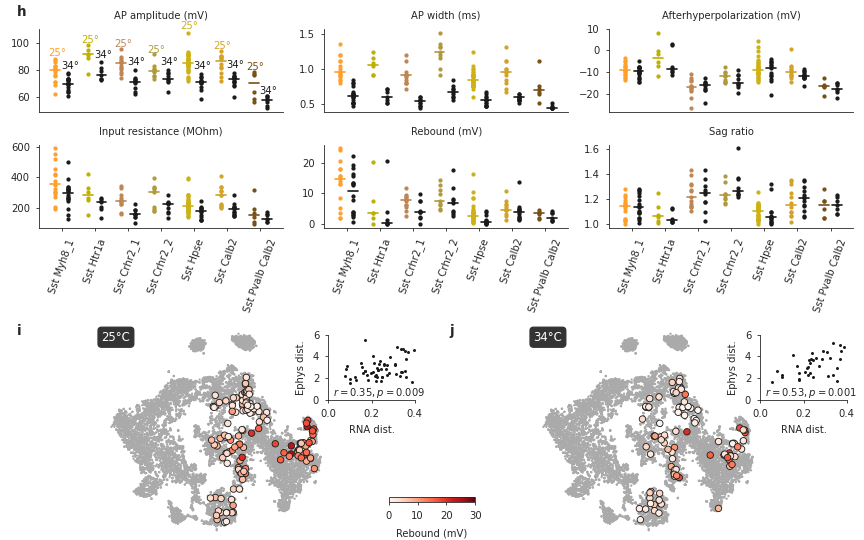

In [13]:
ephysSubset = ['AP amplitude (mV)', 'AP width (ms)', 'Afterhyperpolarization (mV)',
               'Input resistance (MOhm)', 'Rebound (mV)', 'Sag ratio']

fig = plt.figure(figsize=(7.2, 4.5))
for i in range(len(ephysSubset)):
    plt.subplot(2,3,i+1)
    subset   = (ttypes['family']=='Sst') & (layers=='5') & (m1.exclude=='')
    subset34 = (ttypes34['family']=='Sst') & (layers34=='5')
    x = 0
    typesShown = []
    for t in range(clusterN):
        ind = subset & (ttypes['type']==clusterNames[t])
        ind34 = subset34 & (ttypes34['type']==clusterNames[t])
        if (np.sum(ind) >= 5) & (np.sum(ind34) >= 5):
            y = m1.ephys[ind,:][:,m1.ephysNames==ephysSubset[i]]
            plt.scatter(x + np.zeros(np.sum(ind)), y,
                        color = clusterColors[t], s = 3)
            plt.plot([x-.15,x+.15],[np.median(y), np.median(y)], color=clusterColors[t], linewidth=1)
            
            y = m1_34.ephys[ind34,:][:,m1.ephysNames==ephysSubset[i]]
            plt.scatter(x + .4 + np.zeros(np.sum(ind34)), y,
                        color = 'k', s = 3)
            plt.plot([x+.25,x+.55],[np.median(y), np.median(y)], color='k', linewidth=1)

            if i==0:
                y1 = min(m1.ephys[ind,:][:,m1.ephysNames==ephysSubset[i]])
                y2 = max(m1.ephys[ind,:][:,m1.ephysNames==ephysSubset[i]])
                plt.text(x + .05, y2 + (y2-y1)/15,
                         '25°', fontsize=6, color=clusterColors[t], ha='center')
                
                y1 = min(m1_34.ephys[ind34,:][:,m1.ephysNames==ephysSubset[i]])
                y2 = max(m1_34.ephys[ind34,:][:,m1.ephysNames==ephysSubset[i]])
                plt.text(x + .45, y2 + (y2-y1)/5,
                         '34°', fontsize=6, color='k', ha='center')
            x += 1
            typesShown.append(t)

    plt.title(ephysSubset[i])
    if i>=3:
        plt.xticks(np.arange(x)+.2, clusterNames[typesShown], rotation=70)
    else:
        plt.xticks([])
            
sns.despine()
plt.tight_layout(rect=(0,0.4,1,1))

ax25 = plt.axes([0,0,.5,.4])
ax34 = plt.axes([.5,0,.5,.4])
ax_cbr = plt.axes([.45,.07,.1,.01])
ax25_sc = plt.axes([.38,.26,.1,.12])
ax34_sc = plt.axes([.88,.26,.1,.12])

fig.text(.02, .99, 'h', fontsize=8, fontweight='bold', va='top')
fig.text(.02, .4, 'i', fontsize=8, fontweight='bold', va='top')
fig.text(.52, .4, 'j', fontsize=8, fontweight='bold', va='top');

In [14]:
ephys_features_exclude = ['Afterdepolarization (mV)', 'AP Fano factor', 'ISI Fano factor', 
                    'Latency @ +20pA current (ms)', 'Wildness', 'Spike frequency adaptation',
                    'Sag area (mV*s)', 'Sag time (s)', 'Burstiness',
                    'AP amplitude average adaptation index', 'ISI average adaptation index',
                    'Rebound number of APs']

selection = (layers=='5') & (ttypes['family']=='Sst') & (m1.exclude=='') & \
            ~np.isnan(np.sum(m1.ephys[:, ~np.isin(m1.ephysNames, ephys_features_exclude)], axis=1)) & \
            (ttypes['type'] != 'Sst Chodl')
family = 'pvsst'
print(np.sum(selection))

Z = pickle.load(open('../data/processed/rnaseq/10x-tsne-' + family + '.pickle', 'rb'))
m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))
pos = rnaseqTools.map_to_tsne(m1data[family]['counts'], m1data[family]['genes'],
                              m1.exonCounts[selection,:], m1.genes, Z, knn=10,
                              newIntronCounts=m1.intronCounts[selection,:], 
                              newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
                              normalizeNew=True, normalizeReference=False)

col = m1.ephys[selection,:][:, m1.ephysNames=='Rebound (mV)'].squeeze()

plt.sca(ax25)
# ax = plt.subplot(121)
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=2, edgecolor='none', c='#aaaaaa', rasterized=True)
plt.scatter(pos[:,0], pos[:,1], edgecolor='k', linewidth=.5, c=col, cmap='Reds', 
            s=15, vmin=0, vmax=30, zorder=2)
# plt.title('25C')
plt.text(-75,65, '25°C', fontsize=7, color='w', 
         bbox = dict(boxstyle='round', ec='#333333', fc='#333333'))
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax25, left=True, bottom=True)

# plt.colorbar(label='Rebound (mV)', orientation='horizontal', cax=ax_sst_cbr, ticks=[0,10,20,30]);


selection = (layers34=='5') & (ttypes34['family']=='Sst') & \
            ~np.isnan(np.sum(m1_34.ephys[:, ~np.isin(m1.ephysNames, ephys_features_exclude)], axis=1)) & \
            (ttypes34['type'] != 'Sst Chodl')
print(np.sum(selection))

pos = rnaseqTools.map_to_tsne(m1data[family]['counts'], m1data[family]['genes'],
                              m1_34.exonCounts[selection,:], genes, Z, knn=10,
                              newIntronCounts=m1_34.intronCounts[selection,:], 
                              newExonLengths=m1_34.exonLengths, newIntronLengths=m1_34.intronLengths,
                              normalizeNew=True, normalizeReference=False)

col = m1_34.ephys[selection,:][:, m1.ephysNames=='Rebound (mV)'].squeeze()

plt.sca(ax34)
# ax = plt.subplot(122)
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=2, edgecolor='none', c='#aaaaaa', rasterized=True)
plt.scatter(pos[:,0], pos[:,1], edgecolor='k', linewidth=.5, c=col, cmap='Reds', 
            s=15, vmin=0, vmax=30, zorder=2)
# plt.title('34C')
plt.text(-75,65, '34°C', fontsize=7, color='w', 
         bbox = dict(boxstyle='round', ec='#333333', fc='#333333'))
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax34, left=True, bottom=True)

plt.colorbar(label='Rebound (mV)', orientation='horizontal', cax=ax_cbr, ticks=[0,10,20,30]);

# plt.tight_layout()

143
Using a common set of 493 genes.
101
Using a common set of 473 genes.


In [15]:
selection = (layers=='5') & (ttypes['family']=='Sst') & (m1.exclude=='') & \
            ~np.isnan(np.sum(m1.ephys[:, ~np.isin(m1.ephysNames, ephys_features_exclude)], axis=1)) & \
            (ttypes['type'] != 'Sst Chodl')

ephys_features_log = ['AP coefficient of variation', 'ISI coefficient of variation', 
                      'ISI adaptation index', 'Latency (ms)']

ephysTransformed = m1.ephys.copy()
for e in ephys_features_log:
    ephysTransformed[:, m1.ephysNames==e] = np.log(ephysTransformed[:, m1.ephysNames==e])
ephysTransformed = ephysTransformed[:, ~np.isin(m1.ephysNames, ephys_features_exclude)]
nonans = ~np.isnan(np.sum(ephysTransformed, axis=1))

ephysTransformed = ephysTransformed - np.mean(ephysTransformed[nonans,:], axis=0)
ephysTransformed = ephysTransformed / np.std(ephysTransformed[nonans,:], axis=0)

from scipy.spatial.distance import pdist

meanTypePhenotype = np.zeros((clusterN, ephysTransformed.shape[1])) * np.nan

for c in range(clusterN):
    ind = selection & (ttypes['type'] == clusterNames[c])
    if np.sum(ind) >= 5:
        meanTypePhenotype[c,:] = np.mean(ephysTransformed[ind,:], axis=0)
                    
meanTypeRNA = np.zeros((clusterN, m1data[family]['counts'].shape[1])) * np.nan

for c in range(clusterN):
    ind = m1data[family]['clusters'] == c
    if np.sum(ind) >= 10:
        meanTypeRNA[c,:] = np.mean(np.log1p(m1data[family]['counts'][ind,:]), axis=0)
        
haveinfo = ~np.isnan(meanTypePhenotype[:,0])
print(np.sum(haveinfo))

Dt = pdist(meanTypeRNA[haveinfo,:], metric='correlation')
Dph = pdist(meanTypePhenotype[haveinfo,:])

plt.sca(ax25_sc)
plt.scatter(Dt,Dph, s=1, c='k')
r,p = scipy.stats.pearsonr(Dt,Dph)
plt.text(.05, .05, '$r={:.2f}, p={:.3f}$'.format(r,p), 
         transform=ax25_sc.transAxes, fontsize=6)
sns.despine(ax=ax25_sc)
plt.xlabel('RNA dist.')
plt.ylabel('Ephys dist.')
plt.ylim([0,6])
plt.yticks([0,2,4,6])
plt.xlim([0,0.4])
plt.xticks([0,.2,.4]);

11


In [16]:
selection = (layers34=='5') & (ttypes34['family']=='Sst') & \
            ~np.isnan(np.sum(m1_34.ephys[:, ~np.isin(m1.ephysNames, ephys_features_exclude)], axis=1)) & \
            (ttypes34['type'] != 'Sst Chodl')

ephysTransformed = m1_34.ephys.copy()
for e in ephys_features_log:
    ephysTransformed[:, m1.ephysNames==e] = np.log(ephysTransformed[:, m1.ephysNames==e])
ephysTransformed = ephysTransformed[:, ~np.isin(m1.ephysNames, ephys_features_exclude)]
nonans = ~np.isnan(np.sum(ephysTransformed, axis=1))

ephysTransformed = ephysTransformed - np.mean(ephysTransformed[nonans,:], axis=0)
ephysTransformed = ephysTransformed / np.std(ephysTransformed[nonans,:], axis=0)

meanTypePhenotype = np.zeros((clusterN, ephysTransformed.shape[1])) * np.nan

for c in range(clusterN):
    ind = selection & (ttypes34['type'] == clusterNames[c])
    if np.sum(ind) >= 5:
        meanTypePhenotype[c,:] = np.mean(ephysTransformed[ind,:], axis=0)
                            
haveinfo = ~np.isnan(meanTypePhenotype[:,0])
print(np.sum(haveinfo))

Dt = pdist(meanTypeRNA[haveinfo,:], metric='correlation')
Dph = pdist(meanTypePhenotype[haveinfo,:])

plt.sca(ax34_sc)
plt.scatter(Dt,Dph, s=1, c='k')
r,p = scipy.stats.pearsonr(Dt,Dph)
plt.text(.05, .05, '$r={:.2f}, p={:.3f}$'.format(r,p), 
         transform=ax34_sc.transAxes, fontsize=6)
sns.despine(ax=ax34_sc)
plt.xlabel('RNA dist.')
plt.ylabel('Ephys dist.')
plt.ylim([0,6])
plt.yticks([0,2,4,6])
plt.xlim([0,0.4])
plt.xticks([0,.2,.4]);

9


In [17]:
plt.savefig('../figures/suppfigures/sst-comparison-layer5.png', dpi=300)
plt.savefig('../figures/suppfigures/pdf/sst-comparison-layer5.pdf', dpi=300)

## IT/ET

In [18]:
# Features with the strongest difference between L5 IT and L5 ET

from scipy.stats import mannwhitneyu
ps = np.zeros(m1.ephys.shape[1])
for i in range(m1.ephys.shape[1]):
    if i==20:
        ps[i] = 1
    else:
        ps[i] = mannwhitneyu(m1.ephys[(ttypes['family']=='IT') & (layers=='5') & (m1.exclude==''), i],
                             m1.ephys[(ttypes['family']=='ET') & (layers=='5') & (m1.exclude==''), i])[1]

order = np.argsort(ps)
print(m1.ephysNames[order])
print('')

# Features with the strongest difference between L5 IT and L5 PT

ps = np.zeros(m1.ephys.shape[1])
for i in range(m1.ephys.shape[1]):
    if i==20:
        ps[i] = 1
    else:
        ps[i] = mannwhitneyu(m1_34.ephys[(ttypes34['family']=='IT') & (layers34=='5'), i],
                             m1_34.ephys[(ttypes34['family']=='ET') & (layers34=='5'), i])[1]

order = np.argsort(ps)
print(m1.ephysNames[order])

['Sag ratio' 'Input resistance (MOhm)' 'AP width (ms)'
 'Upstroke-to-downstroke ratio' 'Sag time (s)' 'Sag area (mV*s)'
 'Rebound (mV)' 'Afterhyperpolarization (mV)' 'Latency (ms)'
 'Rheobase (pA)' 'Latency @ +20pA current (ms)' 'AP threshold (mV)'
 'AP amplitude (mV)' 'Max number of APs' 'ISI average adaptation index'
 'Burstiness' 'Spike frequency adaptation' 'Wildness' 'AP Fano factor'
 'AP coefficient of variation' 'ISI coefficient of variation'
 'Membrane time constant (ms)' 'Resting membrane potential (mV)'
 'AP amplitude adaptation index' 'Afterdepolarization (mV)'
 'AP amplitude average adaptation index' 'ISI adaptation index'
 'ISI Fano factor' 'Rebound number of APs']

['Input resistance (MOhm)' 'AP threshold (mV)'
 'Spike frequency adaptation' 'Upstroke-to-downstroke ratio'
 'AP width (ms)' 'AP coefficient of variation' 'AP Fano factor'
 'Afterhyperpolarization (mV)' 'ISI Fano factor'
 'ISI coefficient of variation' 'Sag ratio' 'Membrane time constant (ms)'
 'AP amplitude av

<IPython.core.display.Javascript object>


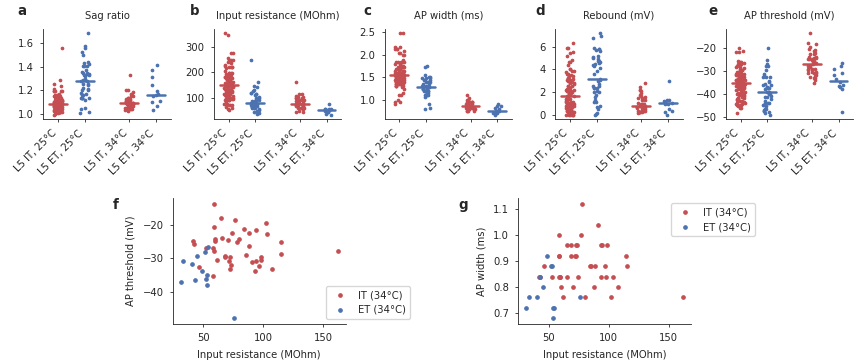

In [19]:
featuresToShow = ['Sag ratio', 'Input resistance (MOhm)', 'AP width (ms)', 'Rebound (mV)', 'AP threshold (mV)']

np.random.seed(42)

fig=plt.figure(figsize=(7.2, 3))
for i,f in enumerate(featuresToShow):
    plt.subplot(2, len(featuresToShow), i+1)
    
    subset   = (ttypes['family']=='IT') & (layers=='5') & (m1.exclude=='')
    y = m1.ephys[subset,:][:,m1.ephysNames==f]
    plt.scatter(np.random.rand(np.sum(subset))/2, 
                y, color = 'r', s = 2)
    plt.plot([-.25,.75], [np.median(y), np.median(y)], color='r', linewidth=1.5)
    
    subset   = (ttypes['family']=='ET') & (layers=='5') & (m1.exclude=='')
    y = m1.ephys[subset,:][:,m1.ephysNames==f]
    plt.scatter(1.5 + np.random.rand(np.sum(subset))/2, 
                y, color = 'b', s = 2)
    plt.plot([1.25,2.25], [np.median(y), np.median(y)], color='b', linewidth=1.5)
    
    subset   = (ttypes34['family']=='IT') & (layers34=='5')
    y = m1_34.ephys[subset,:][:,m1.ephysNames==f]
    plt.scatter(4 + np.random.rand(np.sum(subset))/2, 
                y, color = 'r', s = 2)
    plt.plot([3.75,4.75], [np.nanmedian(y), np.nanmedian(y)], color='r', linewidth=1.5)

    subset   = (ttypes34['family']=='ET') & (layers34=='5')
    y = m1_34.ephys[subset,:][:,m1.ephysNames==f]
    plt.scatter(5.5 + np.random.rand(np.sum(subset))/2, 
                y, color = 'b', s = 2)
    plt.plot([5.25,6.25], [np.median(y), np.median(y)], color='b', linewidth=1.5)
    
    plt.xticks([.25,1.75,4.25,5.75], 
               ['L5 IT, 25°C', 'L5 ET, 25°C', 'L5 IT, 34°C', 'L5 ET, 34°C'],
               rotation=45, ha='right')
    
    plt.title(f)
    
fig.text(.02, .99, 'a', fontsize=8, fontweight='bold', va='top')
fig.text(.22, .99, 'b', fontsize=8, fontweight='bold', va='top')
fig.text(.42, .99, 'c', fontsize=8, fontweight='bold', va='top')
fig.text(.62, .99, 'd', fontsize=8, fontweight='bold', va='top')
fig.text(.82, .99, 'e', fontsize=8, fontweight='bold', va='top')

sns.despine()
plt.tight_layout(rect=(0,.2,1,1))

plt.axes([.2,.1,.2,.35])
subset   = (ttypes34['family']=='IT') & (layers34=='5') 
plt.scatter(m1_34.ephys[subset,:][:,m1.ephysNames=='Input resistance (MOhm)'],
            m1_34.ephys[subset,:][:,m1.ephysNames=='AP threshold (mV)'], s = 4, color='r')

subset   = (ttypes34['family']=='ET') & (layers34=='5')
plt.scatter(m1_34.ephys[subset,:][:,m1.ephysNames=='Input resistance (MOhm)'],
            m1_34.ephys[subset,:][:,m1.ephysNames=='AP threshold (mV)'], s = 4, color='b')
plt.xlabel('Input resistance (MOhm)')
plt.ylabel('AP threshold (mV)')
plt.legend(['IT (34°C)', 'ET (34°C)'], loc='lower right', bbox_to_anchor=[1.4,0])

plt.axes([.6,.1,.2,.35])
subset   = (ttypes34['family']=='IT') & (layers34=='5') 
plt.scatter(m1_34.ephys[subset,:][:,m1.ephysNames=='Input resistance (MOhm)'],
            m1_34.ephys[subset,:][:,m1.ephysNames=='AP width (ms)'], s = 4, color='r')

subset   = (ttypes34['family']=='ET') & (layers34=='5')
plt.scatter(m1_34.ephys[subset,:][:,m1.ephysNames=='Input resistance (MOhm)'],
            m1_34.ephys[subset,:][:,m1.ephysNames=='AP width (ms)'], s = 4, color='b')
plt.xlabel('Input resistance (MOhm)')
plt.ylabel('AP width (ms)')
plt.legend(['IT (34°C)', 'ET (34°C)'], bbox_to_anchor=[1.4,1])

sns.despine()

fig.text(.13, .45, 'f', fontsize=8, fontweight='bold', va='top')
fig.text(.53, .45, 'g', fontsize=8, fontweight='bold', va='top')

plt.savefig('../figures/suppfigures/it-pt-temperature.png', dpi=300)
plt.savefig('../figures/suppfigures/pdf/it-pt-temperature.pdf')